In [42]:
import datetime

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import scipy as sp
import pingouin as pg
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [43]:
def partial_correlation(x, y, z, corr_type='pearson'):
    x = np.array(x, dtype=float).ravel()
    y = np.array(y, dtype=float).ravel()

    if not isinstance(z, (list, tuple)):
        z = [z]

    z = [np.array(var, dtype=float).ravel() for var in z]

    lengths = np.unique([len(arr) for arr in [x, y, *z]])
    if len(lengths) > 1:
        raise ValueError("Все массивы (x, y и z) должны быть одинаковой длины.")

    data = pd.DataFrame({'x': x, 'y': y})
    for i, z_var in enumerate(z):
        data[f'z{i}'] = z_var

    covar_names = [f'z{i}' for i in range(len(z))]

    result = pg.partial_corr(data=data, x='x', y='y', covar=covar_names, method=corr_type)

    r = result['r'].values[0]
    p = result['p-val'].values[0]

    return r, p


def get_partial_corr_mat(df, corr_type='pearson'):
    cols = df.columns
    n = len(cols)

    corr_matrix = pd.DataFrame(np.eye(n), columns=cols, index=cols)
    pval_matrix = pd.DataFrame(np.eye(n), columns=cols, index=cols)

    for i in range(n):
        for j in range(i + 1, n):
            var1, var2 = cols[i], cols[j]
            covars = [col for col in cols if col not in (var1, var2)]

            x = df[var1]
            y = df[var2]
            z = [df[covar] for covar in covars]

            r, p = partial_correlation(x, y, z, corr_type=corr_type)

            corr_matrix.loc[var1, var2] = r
            corr_matrix.loc[var2, var1] = r
            pval_matrix.loc[var1, var2] = p
            pval_matrix.loc[var2, var1] = p

    return corr_matrix, pval_matrix

def cohens_d(group1, group2):
    mean_diff = np.mean(group1) - np.mean(group2)

    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)

    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))

    d = mean_diff / pooled_std
    return d

In [44]:
deals = pd.read_csv('../data/deals.csv')

In [45]:
deals['Дата ввода в эксплуатацию'] = pd.to_datetime(deals['Дата ввода в эксплуатацию'])
deals['Плановая дата РВЭ'] = pd.to_datetime(deals['Плановая дата РВЭ'])
deals['Дата договора (месяц.год)'] = pd.to_datetime(deals['Дата договора (месяц.год)'])
deals['Дата начала продаж'] = pd.to_datetime(deals['Дата начала продаж'])

deals['Дней после начала продаж'] = (deals['Дата договора (месяц.год)'] - deals['Дата начала продаж']).dt.days
deals['Дней до ввода в эксплуатацию'] = (deals['Дата ввода в эксплуатацию'] - deals['Дата договора (месяц.год)']).dt.days
deals['Дней между началом продаж и вводом в эксплуатацию'] = (deals['Дата ввода в эксплуатацию'] - deals['Дата начала продаж']).dt.days

deals = deals.sort_values(by='Дата договора (месяц.год)')
# ВНИМАНИЕ! Мы все считаем верно. В ходе длинного анализа сайтов застройщика и разговоров с экспертом мы поняли как счиатть верно
# Если корпус введен в эксплуатацию, то 'Плановая дата РВЭ' является фактической датой получения РВЭ
# А 'Дата ввода в эксплуатацию' это дата, которую пообещали при продаже квартиры
# Мы вычитаем из фактической даты РВЭ самую первую дату-обещания
deals['Задержка в днях'] = (
    deals['Плановая дата РВЭ'] -
    deals.groupby('ID корпуса')['Дата ввода в эксплуатацию'].transform('first')
).dt.days
deals['Задержка'] = deals['Задержка в днях'] > 0
deals['Сдача в срок'] = deals['Задержка в днях'] == 0
deals['Ранняя сдача'] = deals['Задержка в днях'] < 0

deals['Уступка'] = deals['Уступка'].apply(lambda val: val if isinstance(val, bool) else val == 'Договор уступки')

result = deals.groupby('ID корпуса').agg(
    total=('Уступка', 'size'),
    assignments=('Уступка', 'sum')
)

assignment_rates = (
    deals.groupby('Название ЖК')
    .agg(
        total=('Уступка', 'size'),
        assignments=('Уступка', 'sum')
    )
    .reset_index()
)

assignment_rates['Доля уступок'] = (assignment_rates['assignments'] / assignment_rates['total']) * 100

deals = pd.merge(
    deals,
    assignment_rates[['Название ЖК', 'Доля уступок']],
    on='Название ЖК',
    how='left'
)

highway_cols = [
    'Расстояние до шоссе Калужское',
    'Расстояние до шоссе Киевское',
    'Расстояние до шоссе Варшавское',
    'Расстояние до шоссе Боровское'
]

deals['Минимальное расстояние до шоссе'] = deals[highway_cols].min(axis=1)


deals['Объем'] = deals['Общая проектная площадь'] * deals['Этажей до']


In [46]:
def filter(deals, condition):
    prev = len(deals)
    deals = deals[condition]
    print(len(deals) / prev)
    return deals

print('Before:', len(deals))
deals = filter(deals, deals['Цена квадратного метра'] < 500_000) # Удалили большие значения
deals = filter(deals, ~np.isnan(deals['Плановая дата РВЭ'])) # Удалим один NaN
deals = filter(deals, deals['Плановая дата РВЭ'] <= datetime.datetime(2025, 11, 1))
deals = filter(deals, deals['Расстояние до МКАД'] < 19)
print('After:', len(deals))

Before: 50955
0.9835344912177412
0.9999800462926012
0.5136785393594732
0.9304665345919279
After: 23953


<Axes: xlabel='Расстояние до МКАД', ylabel='Задержка в днях'>

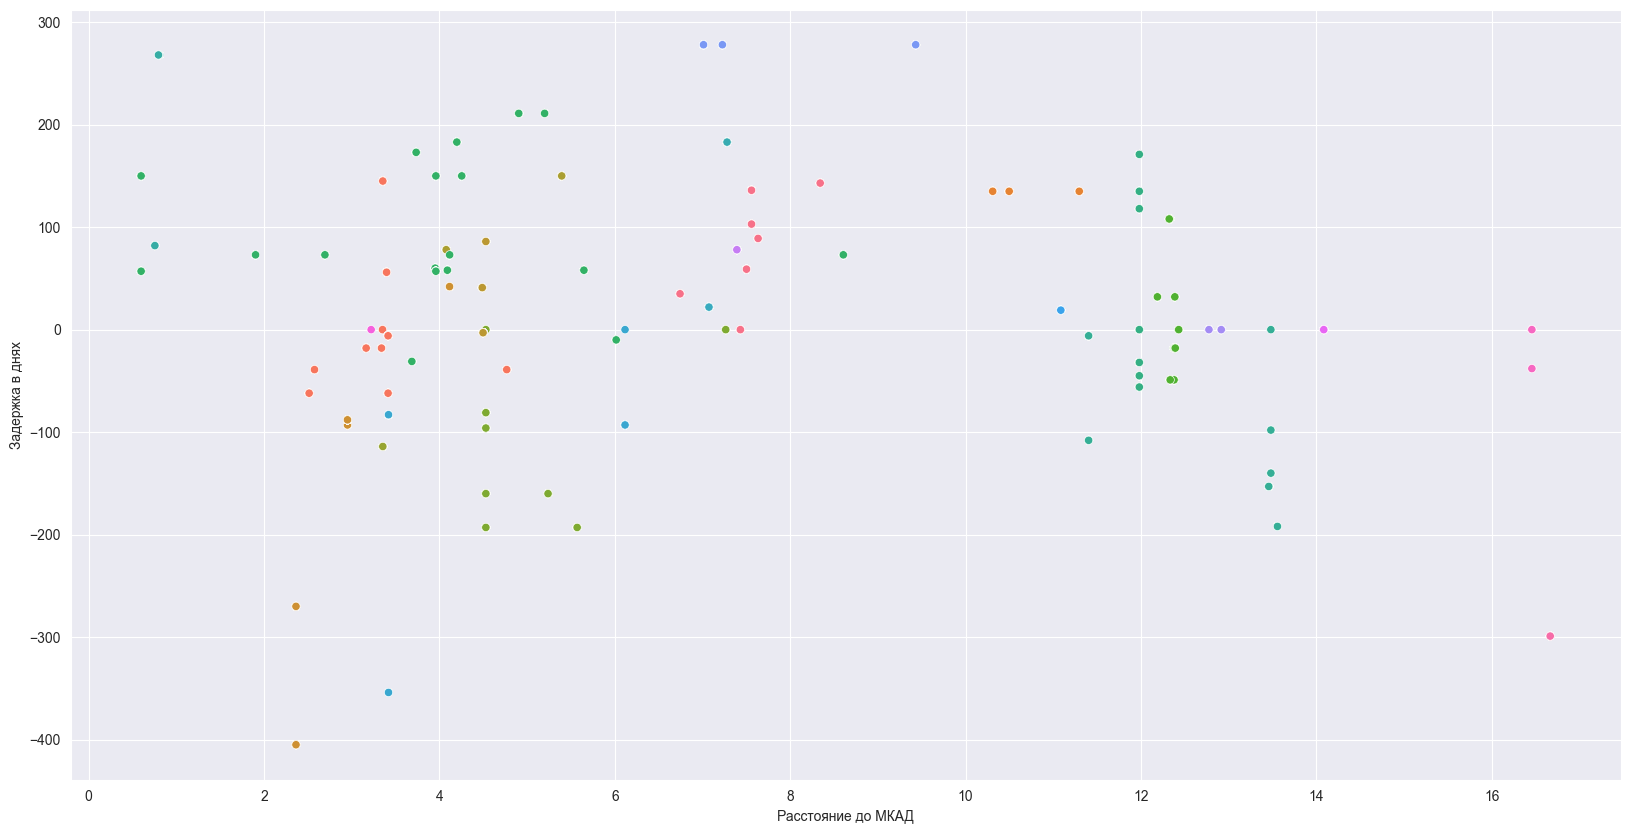

In [47]:
df = deals.copy()
plt.figure(figsize=(20, 10))
sns.scatterplot(x='Расстояние до МКАД', y='Задержка в днях', data=df,  hue='Название ЖК', legend=None)

0.0

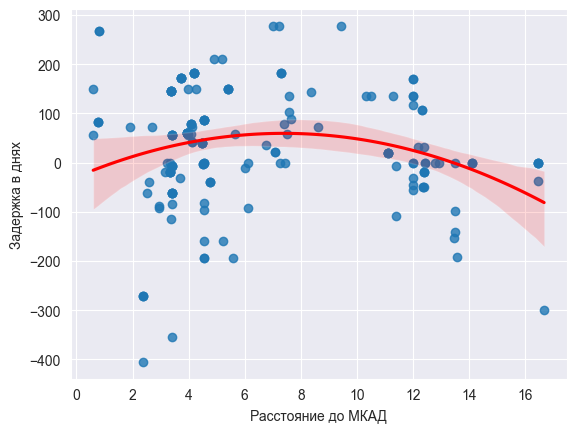

In [48]:
df = deals.groupby(['ID корпуса'])[['Расстояние до МКАД', 'Задержка в днях']].median()
sns.regplot(x='Расстояние до МКАД', y='Задержка в днях', data=df, order=2, line_kws={'color': 'red'})

len(df[df['Расстояние до МКАД'] > 19]) / len(df)

<Axes: xlabel='Расстояние до МКАД', ylabel='Задержка в днях'>

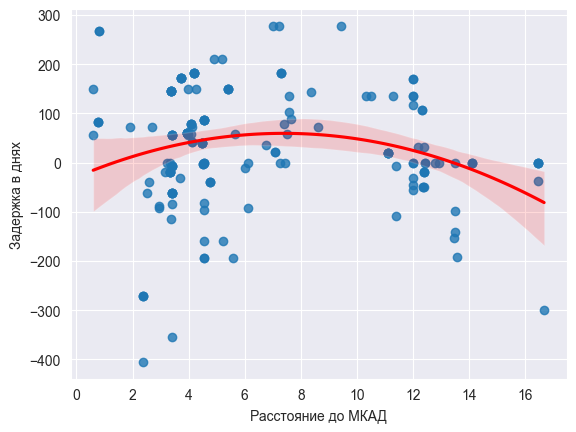

In [49]:
deals
df = deals.groupby(['ID корпуса'])[['Расстояние до МКАД', 'Задержка в днях']].median()
sns.regplot(x='Расстояние до МКАД', y='Задержка в днях', data=df, order=2, line_kws={'color': 'red'})

In [50]:
df = deals.copy()

df['Самолет'] = df['Застройщик'] == 'Самолет'
df['ПИК'] = df['Застройщик'] == 'ПИК'
df['А101'] = df['Застройщик'] == 'А101'

X_cols = [
    'Расстояние до МКАД',
    'Общая проектная площадь',
    'Цена квадратного метра',
    'Этажей до',
    'Самолет',
    'ПИК',
    'А101'
]
X_col_extra = 'Квадрат расстояния до МКАД'

y_col = 'Задержка в днях'

df = df.groupby(['ID корпуса'])[X_cols + [y_col]].median()

X = df[X_cols]
columns = X.columns
y = df[y_col]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X_cols, index=X.index)

X_scaled[X_col_extra] = np.pow(X_scaled['Расстояние до МКАД'], 2)
X_cols = X_cols + [X_col_extra]

X = sm.add_constant(X_scaled)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Задержка в днях   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     12.78
Date:                Mon, 15 Dec 2025   Prob (F-statistic):           2.56e-14
Time:                        21:53:47   Log-Likelihood:                -1062.2
No. Observations:                 179   AIC:                             2142.
Df Residuals:                     170   BIC:                             2171.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [51]:
vif_data = pd.DataFrame()

vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

,Feature,VIF
0,const,2.504299
1,Расстояние до МКАД,3.401181
2,Общая проектная площадь,1.591579
3,Цена квадратного метра,1.608586
4,Этажей до,1.424623
5,Самолет,1.816133
6,ПИК,2.074008
7,А101,4.678639
8,Квадрат расстояния до МКАД,2.168680


In [52]:
def f(val: int):
    if val > 12:
        return "Далеко"
    elif val > 6:
        return "Средне"
    else:
        return "Близко"

deals['Тип удаленности'] = deals['Расстояние до МКАД'].apply(f)

order = ["Близко", "Средне", "Далеко"]
deals['Тип удаленности'] = deals['Тип удаленности'].astype("category")
deals['Тип удаленности'] = deals['Тип удаленности'].cat.set_categories(order, ordered=True)

In [53]:
df1 = deals[deals['Тип удаленности'] == 'Далеко']
df2 = deals[deals['Тип удаленности'] == 'Средне']
df3 = deals[deals['Тип удаленности'] == 'Близко']

print(df2['Название ЖК'].unique())

['Переделкино Ближнее' 'Новые Ватутинки. Заречный квартал' 'Остафьево'
 'Первый Московский' 'Юнино' 'Эко Бунино / Южное Бунино' 'Бунинские луга'
 'Новые Ватутинки. Центральный квартал' 'Скандинавия' 'Городские Истории'
 'Рассказоvо' 'Середневский лес']


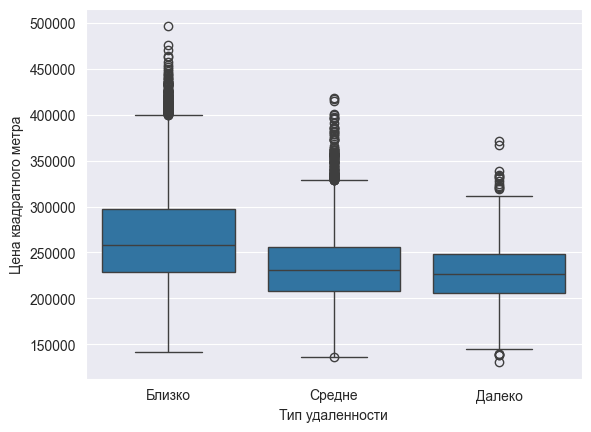

226004.6098439376 224640.0
Разница цены: 1364.6098439375928
Cohen'd -0.06320641457352198
MannwhitneyuResult(statistic=np.float64(7090029.0), pvalue=np.float64(0.9954883561871649))


In [54]:
sns.boxplot(data=deals, x='Тип удаленности', y='Цена квадратного метра')
plt.show()

df = deals[deals['Класс'] == 'Комфорт']

df1 = df[df['Тип удаленности'] == 'Далеко']
df2 = df[df['Тип удаленности'] == 'Средне']
df3 = df[df['Тип удаленности'] == 'Близко']

med1 = df1['Цена квадратного метра'].median()
med2 = df2['Цена квадратного метра'].median()

print(med1, med2)

print(f'Разница цены: {med1 - med2}')
print(f'Cohen\'d {cohens_d(df1['Цена квадратного метра'], df2['Цена квадратного метра'])}')
print(sp.stats.mannwhitneyu(df1['Цена квадратного метра'], df2['Цена квадратного метра']))

                            OLS Regression Results                            
Dep. Variable:        Задержка в днях   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     9.165
Date:                Mon, 15 Dec 2025   Prob (F-statistic):           6.44e-07
Time:                        21:53:47   Log-Likelihood:                -258.65
No. Observations:                  47   AIC:                             535.3
Df Residuals:                      38   BIC:                             552.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

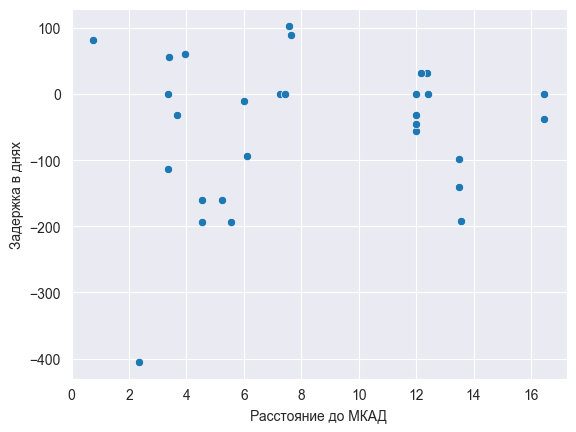

                            OLS Regression Results                            
Dep. Variable:        Задержка в днях   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     10.03
Date:                Mon, 15 Dec 2025   Prob (F-statistic):           1.53e-08
Time:                        21:53:47   Log-Likelihood:                -380.73
No. Observations:                  65   AIC:                             779.5
Df Residuals:                      56   BIC:                             799.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

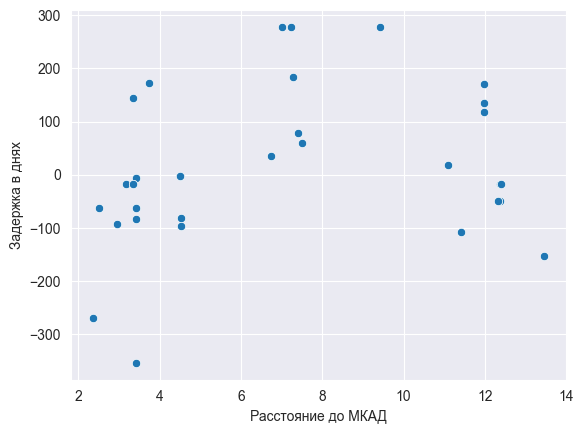

                            OLS Regression Results                            
Dep. Variable:        Задержка в днях   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     6.667
Date:                Mon, 15 Dec 2025   Prob (F-statistic):           7.75e-06
Time:                        21:53:47   Log-Likelihood:                -316.60
No. Observations:                  57   AIC:                             651.2
Df Residuals:                      48   BIC:                             669.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

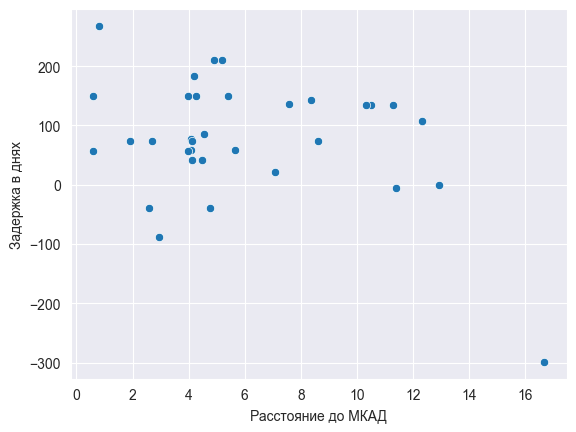

In [55]:
for year in [2023, 2024, 2025]:
    df = deals.copy()
    df = df[(df['Плановая дата РВЭ'] > datetime.datetime(year, 1, 1)) & (df['Плановая дата РВЭ'] < datetime.datetime(year + 1, 1, 1))]


    df['Самолет'] = df['Застройщик'] == 'Самолет'
    df['ПИК'] = df['Застройщик'] == 'ПИК'
    df['А101'] = df['Застройщик'] == 'А101'

    X_cols = [
        'Расстояние до МКАД',
        'Общая проектная площадь',
        'Цена квадратного метра',
        'Этажей до',
        'Самолет',
        'ПИК',
        'А101'
    ]
    X_col_extra = 'Квадрат расстояния до МКАД'

    y_col = 'Задержка в днях'

    df = df.groupby(['ID корпуса'])[X_cols + [y_col]].median()

    X = df[X_cols]
    columns = X.columns
    y = df[y_col]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X_cols, index=X.index)

    X_scaled[X_col_extra] = np.pow(X_scaled['Расстояние до МКАД'], 2)
    X_cols = X_cols + [X_col_extra]

    X = sm.add_constant(X_scaled)

    model = sm.OLS(y, X).fit()
    print(model.summary())
    print(f"YEAR: {year}")
    print(f"Number: {len(df)}")

    sns.scatterplot(data=df, x='Расстояние до МКАД', y='Задержка в днях')
    plt.show()

                            OLS Regression Results                            
Dep. Variable:        Задержка в днях   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     3.371
Date:                Mon, 15 Dec 2025   Prob (F-statistic):            0.00685
Time:                        21:53:48   Log-Likelihood:                -773.47
No. Observations:                 131   AIC:                             1559.
Df Residuals:                     125   BIC:                             1576.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

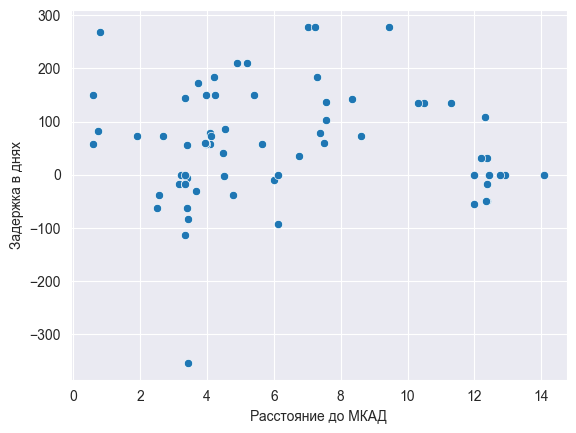

In [56]:
df = deals.copy()
df = df[df['Конструкция объекта'] == 'Монолит-блоки']

X_cols = [
    'Расстояние до МКАД',
    'Общая проектная площадь',
    'Цена квадратного метра',
    'Этажей до',
]
X_col_extra = 'Квадрат расстояния до МКАД'

y_col = 'Задержка в днях'

df = df.groupby(['ID корпуса'])[X_cols + [y_col]].median()

X = df[X_cols]
columns = X.columns
y = df[y_col]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X_cols, index=X.index)

X_scaled[X_col_extra] = np.pow(X_scaled['Расстояние до МКАД'], 2)
X_cols = X_cols + [X_col_extra]

X = sm.add_constant(X_scaled)

model = sm.OLS(y, X).fit()
print(model.summary())
print(len(df))

sns.scatterplot(data=df, x='Расстояние до МКАД', y='Задержка в днях')
plt.show()

                            OLS Regression Results                            
Dep. Variable:        Задержка в днях   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     8.191
Date:                Mon, 15 Dec 2025   Prob (F-statistic):           1.82e-05
Time:                        21:53:48   Log-Likelihood:                -283.90
No. Observations:                  48   AIC:                             579.8
Df Residuals:                      42   BIC:                             591.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

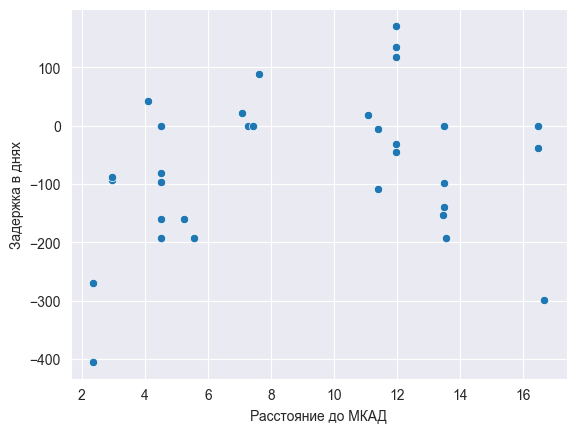

In [57]:
df = deals.copy()
df = df[df['Конструкция объекта'] != 'Монолит-блоки']

X_cols = [
    'Расстояние до МКАД',
    'Общая проектная площадь',
    'Цена квадратного метра',
    'Этажей до',
]
X_col_extra = 'Квадрат расстояния до МКАД'

y_col = 'Задержка в днях'

df = df.groupby(['ID корпуса'])[X_cols + [y_col]].median()

X = df[X_cols]
columns = X.columns
y = df[y_col]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X_cols, index=X.index)

X_scaled[X_col_extra] = np.pow(X_scaled['Расстояние до МКАД'], 2)
X_cols = X_cols + [X_col_extra]

X = sm.add_constant(X_scaled)

model = sm.OLS(y, X).fit()
print(model.summary())
print(len(df))

sns.scatterplot(data=df, x='Расстояние до МКАД', y='Задержка в днях')
plt.show()

                            OLS Regression Results                            
Dep. Variable:        Задержка в днях   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     4.910
Date:                Mon, 15 Dec 2025   Prob (F-statistic):            0.00520
Time:                        21:53:48   Log-Likelihood:                -163.29
No. Observations:                  28   AIC:                             336.6
Df Residuals:                      23   BIC:                             343.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

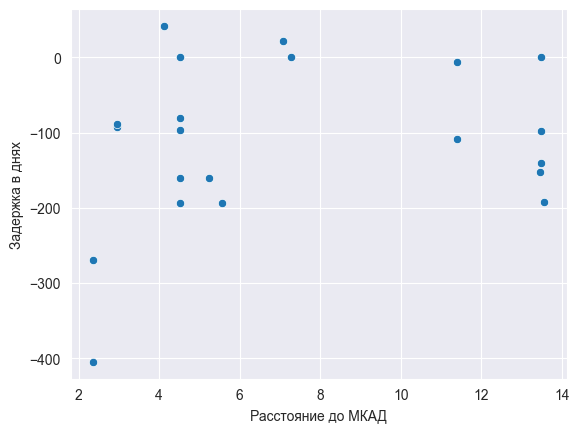

In [58]:
df = deals.copy()
df = df[df['Застройщик'] == 'ПИК']

df['Квадрат расстояния до МКАД'] = np.pow(df['Расстояние до МКАД'], 2)

X_cols = [
    'Расстояние до МКАД',
    'Общая проектная площадь',
    'Этажей до',
    'Квадрат расстояния до МКАД'
]

y_col = 'Задержка в днях'

df = df.groupby(['ID корпуса'])[X_cols + [y_col]].median()

X = df[X_cols]
columns = X.columns
y = df[y_col]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X_cols, index=X.index)

X = sm.add_constant(X_scaled)

model = sm.OLS(y, X).fit()
print(model.summary())

sns.scatterplot(data=df, x='Расстояние до МКАД', y='Задержка в днях')
plt.show()

                            OLS Regression Results                            
Dep. Variable:        Задержка в днях   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     5.225
Date:                Mon, 15 Dec 2025   Prob (F-statistic):           0.000581
Time:                        21:53:48   Log-Likelihood:                -893.47
No. Observations:                 151   AIC:                             1797.
Df Residuals:                     146   BIC:                             1812.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

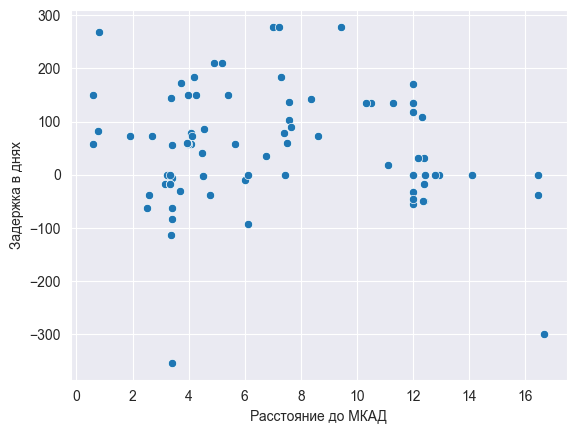

In [59]:
df = deals.copy()
df = df[df['Застройщик'] != 'ПИК']

df['Квадрат расстояния до МКАД'] = np.pow(df['Расстояние до МКАД'], 2)

X_cols = [
    'Расстояние до МКАД',
    'Общая проектная площадь',
    'Этажей до',
    'Квадрат расстояния до МКАД'
]

y_col = 'Задержка в днях'

df = df.groupby(['ID корпуса'])[X_cols + [y_col]].median()

X = df[X_cols]
columns = X.columns
y = df[y_col]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X_cols, index=X.index)

X = sm.add_constant(X_scaled)

model = sm.OLS(y, X).fit()
print(model.summary())

sns.scatterplot(data=df, x='Расстояние до МКАД', y='Задержка в днях')
plt.show()

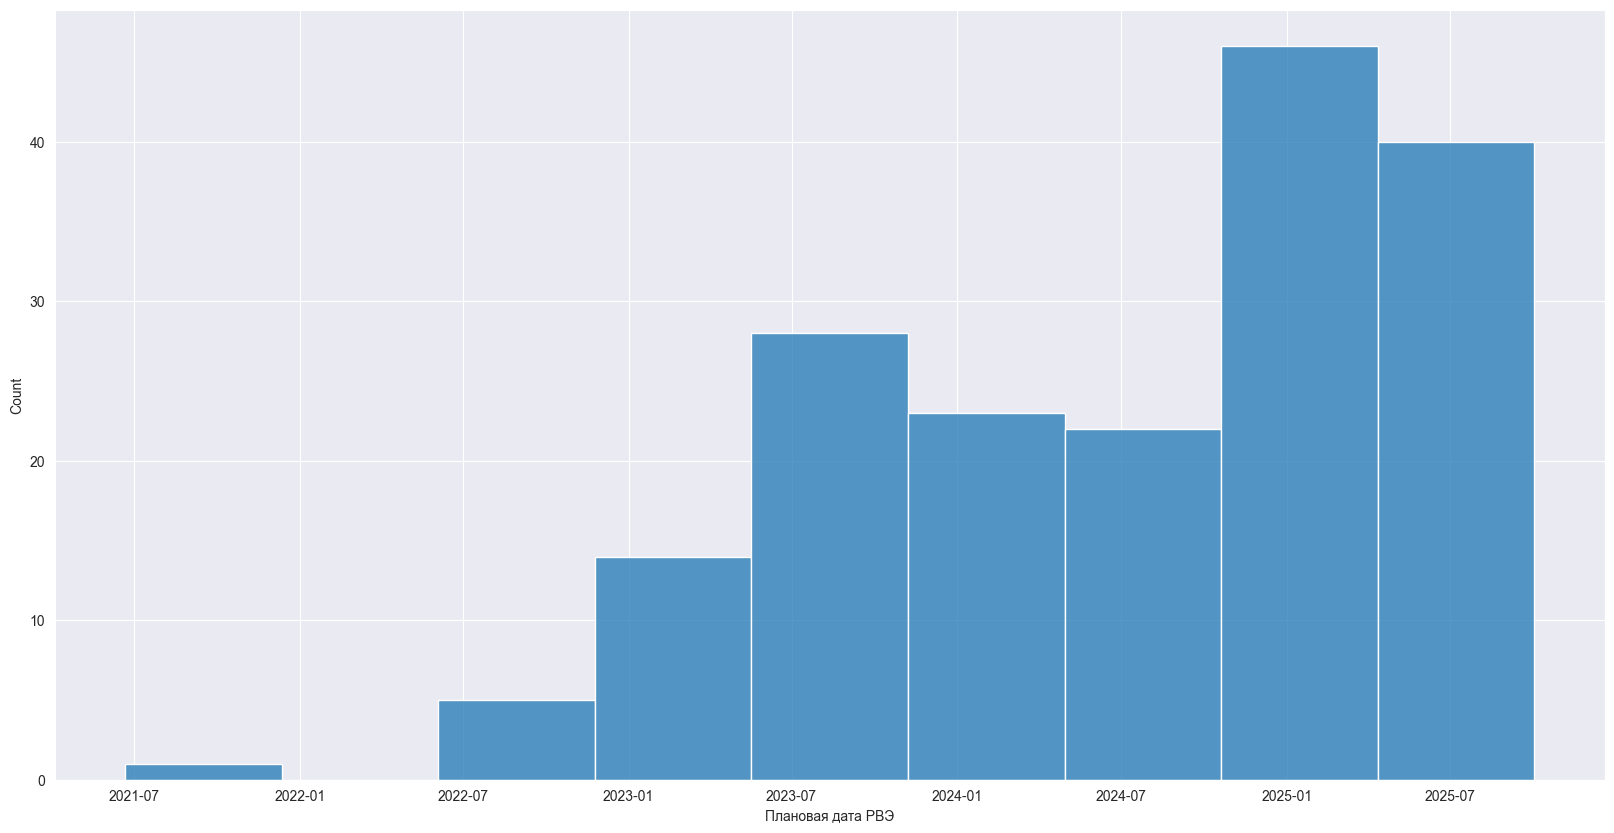

In [60]:
df = pd.DataFrame(deals.groupby(['ID корпуса'])['Плановая дата РВЭ'].first())
plt.figure(figsize=(20, 10))
sns.histplot(data=df, x='Плановая дата РВЭ')
plt.show()